In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/skylab_instagram_datathon_dataset.csv", delimiter=";")

In [190]:
# Convert 'date' column to datetime format
df["period_end_date"] = pd.to_datetime(df['period_end_date'], format="%Y-%m-%d")

# Sort DataFrame by 'date' column in ascending order
df = df.sort_values(by='period_end_date', ascending=True)

In [191]:
df_renamed = df.rename(columns={"business_entity_doing_business_as_name": "brand", "legal_entity_name": "company", "ultimate_parent_legal_entity_name": "parent_company"})

In [204]:
all_brands = df_renamed[df_renamed["brand"] == "All Brands"]
brands = df_renamed[df_renamed["brand"] != "All Brands"]
len(brands)

676558

In [207]:
# Drop data with na for the last 6 years
year_lag = 4
na_brands = ['Simmons', 'LP Building Products', 'East Bay', 'Bottega Veneta',
       "Carter's", 'Sperry', 'Serta', 'Nature Valley', 'Nautica',
       'Bobbi Brown', 'Anta', "OshKosh B'gosh", 'Kanebo',
       'Michelob Ultra', 'Skip Hop', 'Runnerspoint', 'Fashion Nova',
       'Modelo', 'Yoplait', 'Invisalign', 'CertainTeed', 'CCC Shoes',
       'John Frieda', 'Whiskas', 'Vegetarian Butcher', 'Tempur',
       'Breville', 'Schweppes', 'Becca', 'Sizeer', 'iRobot',
       'Ninja Kitchen', 'About You', 'Sensai', 'Izod', 'Restylane',
       'Ecovacs', "Beck's", 'Shark Home', 'Garden Gourmet', 'Revanesse',
       'Sol', 'Elemis', 'Hoegaarden', 'Bulgari Beauty', 'Carla Amorim',
       'Royal Building Products', 'The Meatless Farm', 'Tineco',
       'Roborock', 'Superdown', 'ORCA', 'Burberry Beauty',
       'Pure Farmland', 'Spaten', 'Dysport', 'Sculptra', 'Temu',
       'Finding Unicorn', 'Pop Mart', 'Rolife', 'Wahoo Fitness',
       'Belotero', 'My Shoes', 'Tonica Antarctica', 'Value Village',
       'Pacifico', 'ShopGoodwill']
# Filter the DataFrame
brands = brands[~brands["brand"].isin(na_brands)]

# Print the filtered DataFrame
len(brands)

630721

In [194]:
# Drop unused years
max_date = brands["period_end_date"].max()
brands = brands[brands["period_end_date"] > max_date - pd.DateOffset(years=year_lag)]

In [208]:
brands.head()

,period,period_end_date,compset_group,compset,brand,company,domicile_country_name,parent_company,primary_exchange_name,calculation_type,followers,pictures,videos,comments,likes
77460,Weekly,2015-01-03,Apparel Retail,Latam Apparel Retail,Hering,Hering,Brazil,GRUPO DE MODA SOMA SA,Bolsa de Valores de Sao Paulo (XBSP),Metric Value,NaN,21.0,2.0,360.0,20165.0
495468,Weekly,2015-01-03,Luxury & Premium & Mainstream,Luxury & Premium & Mainstream,Juicy Couture,Juicy Couture,NaN,Authentic Brands Group LLC,NaN,Metric Value,NaN,2.0,NaN,99.0,14041.0
639224,Weekly,2015-01-03,Apparel Retail,Omnichannel Apparel Retail,COS,H&M,Sweden,H&M,Nasdaq Omx Nordic,Metric Value,NaN,2.0,2.0,367.0,14499.0
251008,Weekly,2015-01-03,Beauty & Boutique,Beauty & Boutique,Revlon,Revlon Inc,United States of America,MacAndrews & Forbes Inc_Duplicate,New York Stock Exchange,Metric Value,NaN,132.0,2.0,1959.0,161941.0
29247,Weekly,2015-01-03,Beauty & Boutique,Beauty & Boutique,Balmain Beauty,Mayhoola for Investments Spc,NaN,Mayhoola for Investments Spc,NaN,Metric Value,NaN,20.0,NaN,11.0,301.0


In [195]:
def preprocess_data(data):

    data = data[[ "followers", "likes",  "videos", "pictures", "comments", "period_end_date", "brand"]].copy()
    data['content'] = data['videos'] + data['pictures']
    data['engagement'] = data['likes'] + data['comments']
    data['value'] = data['engagement'] / data['content']
    data = data.drop(["pictures", "followers", "content", "engagement", "videos", "likes", "comments"], axis=1)

    return data

brands = preprocess_data(brands)
#all_brands = preprocess_data(all_brands)

In [196]:
brands.head()

,period_end_date,brand,value
35770,2019-09-21,TAG Heuer,28407.666667
397123,2019-09-21,VO5,63.000000
359996,2019-09-21,Stonyfield Farm,132.888889
95051,2019-09-21,Armani,17736.842767
41132,2019-09-21,Saint Laurent,38304.451613


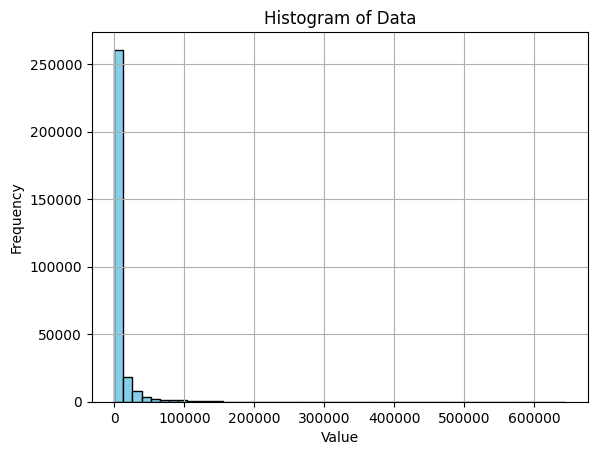

In [197]:
import matplotlib.pyplot as plt

# Plot the data and the regression line
plt.hist(brands["value"].values, bins=50, color='skyblue', edgecolor='black')  # Adjust bins for desired granularity
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(True)
plt.show()

## Model

In [198]:
# Splitting data
limit = brands['period_end_date'].max() - pd.DateOffset(months=3)
train_data = brands[brands['period_end_date'] < limit]
test_data = brands[brands['period_end_date'] >= limit]

In [199]:
train_data.head()

,period_end_date,brand,value
35770,2019-09-21,TAG Heuer,28407.666667
397123,2019-09-21,VO5,63.000000
359996,2019-09-21,Stonyfield Farm,132.888889
95051,2019-09-21,Armani,17736.842767
41132,2019-09-21,Saint Laurent,38304.451613


In [200]:
from sklearn.preprocessing import LabelEncoder

labelers = []
to_label = ["brand"]

for l in to_label:
    labeler = LabelEncoder()
    train_data.loc[:, l] = labeler.fit_transform(train_data[l])
    labelers.append(labeler)

In [181]:
train_data = train_data.drop_duplicates()

In [182]:
train_data["previous_value"] = train_data["value"].shift(1)

In [173]:
train_data.fillna(0)

,period_end_date,brand,value,previous_value
400848,2019-09-21,50,4882.647059,0.000000
276585,2019-09-21,10,1734.718750,4882.647059
569777,2019-09-21,385,4016.847682,1734.718750
331996,2019-09-21,140,408.079727,4016.847682
2298,2019-09-21,371,4942.420000,408.079727
...,...,...,...,...
255793,2023-06-10,325,57.571429,3353.240000
520782,2023-06-10,200,920.333333,57.571429
697110,2023-06-10,356,38.811321,920.333333
459619,2023-06-10,189,862.400000,38.811321


In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Preprocess the data
# Assuming 'period_end_date' is not needed for modeling
features = ['brand', 'previous_value']
target = 'value'

# Group the data by (brand, compset, compset_group)
grouped_data = train_data.groupby('brand')

# Initialize lists to store sequences and targets
sequences = []
targets = []
seq_length = len(train_data["period_end_date"].unique())

# Iterate over each group
for group, group_df in grouped_data:
    # Sort by period_end_date if needed
    group_df = group_df.sort_values(by='period_end_date')
    
    # Extract features and target
    X_group = group_df[features]  # Exclude the 'value' column
    y_group = group_df[target]
    
    # Convert to numpy arrays
    X_group = X_group.values
    y_group = y_group.values
    
    sequences.append(X_group)
    targets.append(y_group)


In [175]:
import numpy as np

# Convert lists to numpy arrays
sequences = np.array(sequences, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

In [176]:
targets.shape, sequences.shape

((420, 195), (420, 195, 2))

In [177]:
targets

array([[ 462.36365,  479.7143 ,  479.05   , ...,  354.32144,  383.5    ,
         358.14285],
       [4292.614  , 4223.397  , 4606.901  , ...,  632.36664,  710.1739 ,
         647.3182 ],
       [1550.7885 , 1207.415  , 1118.7222 , ...,        nan,        nan,
               nan],
       ...,
       [1516.6154 , 1509.0834 , 1538.8462 , ...,  728.6667 ,  682.     ,
         606.05884],
       [7637.2026 , 8447.85   , 8823.1    , ..., 5961.5513 , 6855.893  ,
        7673.4263 ],
       [3027.452  , 3662.126  , 4058.4653 , ..., 1226.7546 , 1218.5175 ,
        1137.303  ]], dtype=float32)

In [166]:
# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, len(features))),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')


# Train model
model.fit(sequences, targets, epochs=10, batch_size=64)

Epoch 1/10


c:\Users\ronan\miniconda3\envs\pai-demos\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: nan
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: nan
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: nan
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: nan
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: nan
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: nan


In [133]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert lists to numpy arrays
sequences = np.array(sequences, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, len(features))),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with autoregression
for epoch in range(10):
    for i in range(len(sequences)):
        # Select a single sequence from the training data
        X_train = sequences[i:i+1]
        y_train = targets[i:i+1]
        
        # Initialize output sequence with random values
        output_sequence = np.random.rand(*y_train.shape)
        
        # Generate predictions and update input sequence with predicted values
        for j in range(seq_length):
            # Predict next value
            prediction = model.predict(X_train[:, j:j+1, :], verbose=0)
            
            # Update output sequence with predicted value
            output_sequence[:, j:j+1] = prediction
            
            # Update input sequence with predicted value
            X_train[:, j+1:j+2, :] = prediction
        
        # Compute loss and perform a single step of gradient descent
        loss = model.train_on_batch(sequences[i:i+1], output_sequence)
    
    # Print loss at the end of each epoch
    print("Epoch:", epoch+1, "Loss:", loss)

# Generate predictions
predictions = model.predict(sequences)

# Calculate MSE
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error:", mse)

c:\Users\ronan\miniconda3\envs\pai-demos\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [134]:
X_train

array([[[ 5.0000000e+00],
        [-1.1862062e-02],
        [ 6.4800197e-04],
        [ 4.6201190e-04],
        [ 4.6499050e-04],
        [ 4.6494277e-04],
        [ 4.6494356e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.6494353e-04],
        [ 4.

In [121]:
# Convert to pivot table to reshape data into sequences
pivot_df = brands.pivot_table(index='period_end_date', columns='brand', values='value', fill_value=0)
pivot_df.head()

brand,24S,3CE,A. Lange & Soehne,ANIMALE,Abercrombie & Fitch,Absolut,Academy Sports + Outdoors,Adidas,Aerie,Alexander McQueen,...,YesStyle,Yves Veggie Cuisine,Zalando,Zales,Zara,Zenith,bareMinerals,dd's Discounts,e.l.f.,shopDisney
period_end_date,,,,,,,,,,,,,,,,,,,,,
2019-09-21,462.363636,4292.613636,1550.788462,2799.000000,11720.156250,573.181818,375.200000,10325.734884,10498.500000,35858.490909,...,8310.130435,135.000000,718.244444,616.434783,55300.152941,2635.814815,946.110429,1516.615385,7637.202479,3027.451852
2019-09-28,479.714286,4223.396947,1207.415094,2305.700000,12177.130435,492.968354,419.071429,11906.115727,9783.582090,35241.844828,...,8241.692857,140.500000,785.987261,738.111111,55192.780488,3140.851852,899.148810,1509.083333,8447.849138,3662.125926
2019-10-05,479.050000,4606.900826,1118.722222,1733.142857,13202.235955,475.291139,423.666667,11074.409692,10534.956522,36088.500000,...,8904.857143,136.142857,833.308176,835.473684,62137.209877,3068.785714,866.957576,1538.846154,8823.099138,4058.465409
2019-10-12,403.428571,5352.573770,1284.055556,1700.225806,13893.151163,445.824242,416.823529,14781.395161,11213.753623,33689.857143,...,10383.899281,142.555556,827.506173,781.952381,64677.743590,3094.730769,799.922619,1657.625000,9609.865801,4904.058201
2019-10-19,406.238095,5150.443548,1261.173077,1688.906250,14522.988372,435.793103,418.823529,16912.980983,12722.492958,33530.147541,...,11506.657143,162.333333,898.223642,850.320000,73407.280000,3457.115385,784.431818,1552.461538,10517.783784,5224.676329


In [ ]:
# Convert to numpy array
data = pivot_df.values

# Prepare input sequences and corresponding targets
X = []
y = []
seq_length = len(train_data["period_end_date"].unique())

for i in range():
    X.append(data[i:i+past_years*12])
    y.append(data[i+past_years*12:i+past_years*12+future_months])

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(future_months)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Generate predictions
predictions = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)